### Apresentação ✒️

Notebook destinado ao estudo da aplicação dos algoritmos hierárquicos. Referem-se a um algoritmo direcionado a cenários de clusterização a partir do qual busca-se compreender os clusters presentes no dataset por meio de uma perspectiva hierárquica, representada em um esquema denominado de dendograma. 

Semelhante à estrutura de uma árvore de decisão, disposta em grafos, o dendograma compreende os clusters presentes com base numa estrutura de grafos, utilizando-se para a apreensão dos clusters presentes da similaridade entre os datapoints e entre clusters. Para a compreensão da semelhança dos datapoints utiliza-se as métricas de distância - como Euclidiana, Manhattan, cosseno etc - enquanto para os clusters ocorre mediante ao nível de conexão determinada - assim como a distância, apresenta mais de um tipo, com cada qual representando uma característica e contribuição para a formação dos clusters.

Uma das grandes vantagens desse algoritmo se dá em conseguir compreender relações complexas dos dados no espaço dimensiona, bem como permitir uma visualização gráfica dos clusters presentes, sem precisar utilizar de técnicas de redução de dimensionalidade. Contudo, importante pontuar que assim como qualquer modelo baseado na magnitude da distância para a formação de seu limiar de decisão - utilizado, aqui, para a descriminação entre os clusters - é sensível a contextos de elevada dimensionalidade, sendo mais robusta, no entanto, quando aplicado a métrica de distância do cosseno, uma vez que não se baseia na magnitude da distância para a sua compreensão, mas no ângulo formado entre os datapoints. 

#### Library 📚

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pandas import DataFrame

from scipy.cluster.hierarchy import (dendrogram, 
                                     linkage)

from sklearn.decomposition import PCA
from sklearn.datasets import load_wine 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import (silhouette_score, 
                             davies_bouldin_score)


from factor_analyzer import calculate_bartlett_sphericity

#### Carregando o dataset 💾

In [3]:
wine = load_wine()

In [4]:
y = wine.target
X = wine.data

df_y = DataFrame(y)
df_y.columns = ["original_label"]

df_x = DataFrame(X)
df_x.columns = [
                'Alcohol', 'Malic_Acid', 'Ash', 'Ash_Alcanity', 'Magnesium',
                'Total_Phenols', 'Flavanoids', 'Nonflavanoid_Phenols',
                'Proanthocyanins', 'Color_Intensity', 'Hue', 'OD280', 'Proline'
                ]

In [5]:
df_x.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [6]:
# Checking how many labels actually exist in this dataset. 
# This will be important for future understanding of quality
# of the elaborated cluster model, in order to evaluate whether it
# also found the number of clusters that exist or not.

df_y.original_label.unique()

array([0, 1, 2])

#### Verificando a integridade do dataset

In [7]:
df_x.isnull().sum()

Alcohol                 0
Malic_Acid              0
Ash                     0
Ash_Alcanity            0
Magnesium               0
Total_Phenols           0
Flavanoids              0
Nonflavanoid_Phenols    0
Proanthocyanins         0
Color_Intensity         0
Hue                     0
OD280                   0
Proline                 0
dtype: int64

In [8]:
df_x.duplicated().sum()

np.int64(0)

#### Scaler

In [9]:
scaler = StandardScaler()

normalized_values = scaler.fit_transform(df_x)

df_normalized = pd.DataFrame(normalized_values, columns=df_x.columns)
df_normalized.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,1.518613,-0.562250,0.232053,-1.169593,1.913905,0.808997,1.034819,-0.659563,1.224884,0.251717,0.362177,1.847920,1.013009
1,0.246290,-0.499413,-0.827996,-2.490847,0.018145,0.568648,0.733629,-0.820719,-0.544721,-0.293321,0.406051,1.113449,0.965242
2,0.196879,0.021231,1.109334,-0.268738,0.088358,0.808997,1.215533,-0.498407,2.135968,0.269020,0.318304,0.788587,1.395148
3,1.691550,-0.346811,0.487926,-0.809251,0.930918,2.491446,1.466525,-0.981875,1.032155,1.186068,-0.427544,1.184071,2.334574
4,0.295700,0.227694,1.840403,0.451946,1.281985,0.808997,0.663351,0.226796,0.401404,-0.319276,0.362177,0.449601,-0.037874


#### Parâmetros

In [10]:
# Parameters to be passed by the hierarchical algorithm.

dendogram_parameters = {
    "method": "ward", 
    "metric": "euclidean", 
    "height_graph": 12, 
    "width_graph": 9
}

#### Algoritmo hierárquico 


In [11]:
# Visualizing the dendrogram to assist in choosing
# the number of clusters does not present a data set.

def dendogram_graph(
        dataset: DataFrame, 
        method: str, 
        metric: str, 
        height_graph: int, 
        width_graph: int
    ):
    """ 
    """
    linkage_matrix = linkage(
        dataset, 
        method             = method, 
        metric             = metric
    )

    plt.figure(figsize=(height_graph, width_graph))

    dendrogram(linkage_matrix, no_labels=True)
    plt.title("Dendogram")
    plt.xlabel("Samples")
    plt.ylabel("Distance")
    plt.show()

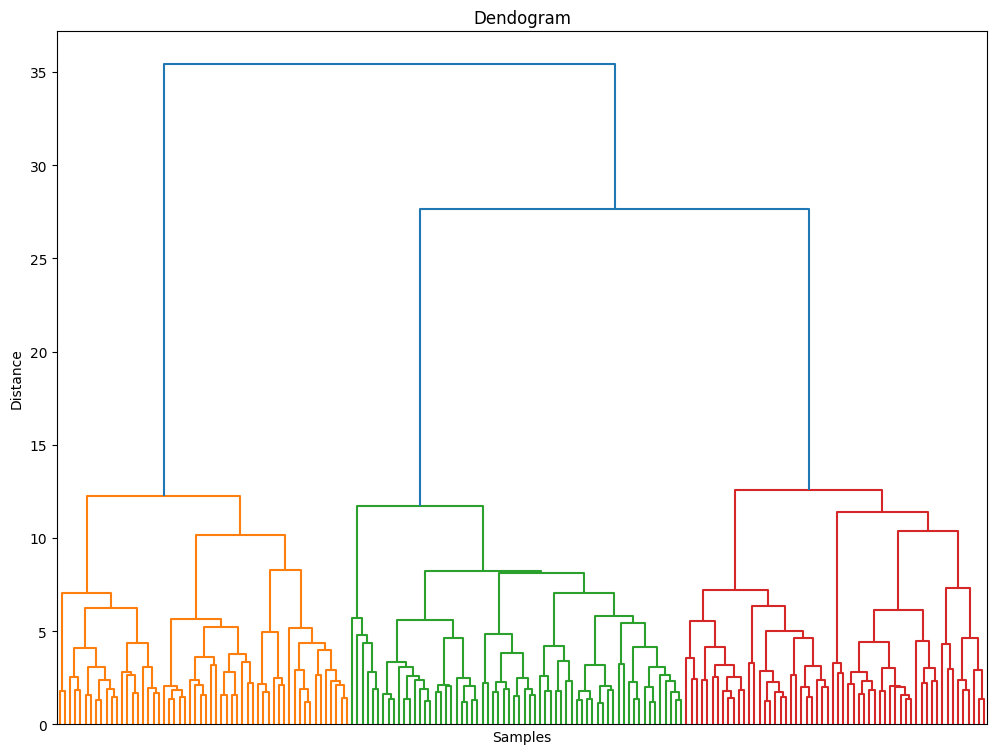

In [12]:
dendogram_graph(
    dataset            = df_normalized,
    method             = dendogram_parameters["method"], 
    metric             = dendogram_parameters["metric"], 
    height_graph       = dendogram_parameters["height_graph"], 
    width_graph        = dendogram_parameters["width_graph"] 
)

In [13]:
h_model = AgglomerativeClustering( 
    n_clusters         = 3,
    linkage            = "ward", 
    metric             = "euclidean", 
)

In [14]:
h_model.fit(df_normalized)

AgglomerativeClustering(n_clusters=3)

In [15]:
# Verify the quality of clusters builded with silhoutte score. 

silhoutte = silhouette_score(
    normalized_values, 
    h_model.labels_, 
    metric="euclidean"
)

print(f"A silhueta do modelo é de aproximadamente {silhoutte.round(3)}")

A silhueta do modelo é de aproximadamente 0.277


In [16]:
# Verify the quality of clusters builded with Davis Bouldin.

davis_bouldin = davies_bouldin_score(
    normalized_values, 
    h_model.labels_
) 

print(f"Índice Davis Bouldin do modelo : {davis_bouldin.round(3)}")

Índice Davis Bouldin do modelo : 1.419


#### Encontrando os clusters adotando o PCA

In [17]:
_, p_value = calculate_bartlett_sphericity(df_normalized)

if p_value < 0.05:
    print(f"O dataset pode ser submetido ao PCA.\nValor-p: {p_value}")
else:
    print("O dataset não pode ser submetido ao PCA, pois o seu valor-p é superior que 5%. ")

O dataset pode ser submetido ao PCA.
Valor-p: 2.468617032425838e-224


In [18]:
def elbow_pca(dataset: DataFrame):
    """ 
    """
    pca = PCA(random_state=20)
    pca.fit(dataset)

    explained_variance  = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)

    plt.figure(figsize=(8, 5))
    plt.plot(
        range(
            1, 
            len(cumulative_variance) + 1
            ), 
            cumulative_variance, 
            marker='o', 
            linestyle='--', 
            color='b'
        )
        
    plt.title('Elbow for PCA')
    plt.xlabel('Principal Components')
    plt.ylabel('Cumulative Variance Explained')
    plt.axhline(y=0.95, color='r', linestyle='--')  # Reference line for 95%
    plt.axhline(y=0.90, color='g', linestyle='--')  # Reference line for 90%
    plt.grid()
    plt.show() 

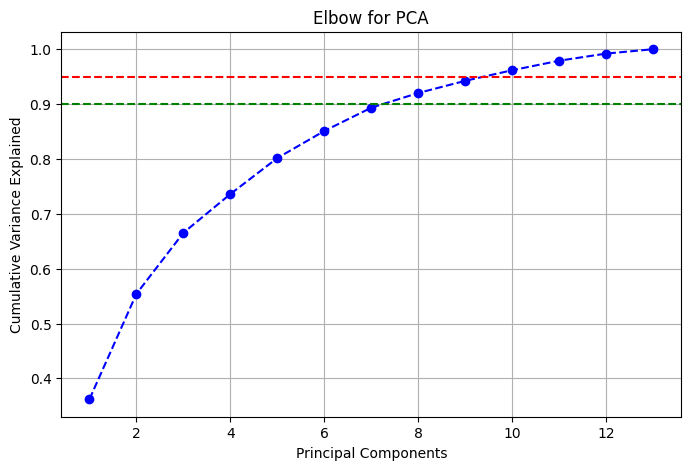

In [19]:
elbow_pca(df_normalized)

In [20]:
pca = PCA(n_components=8, random_state=20)

df_pca = pd.DataFrame(pca.fit_transform(df_normalized))

In [21]:
df_pca.head()

,0,1,2,3,4,5,6,7
0,3.316751,1.443463,-0.165739,-0.215631,0.693043,0.223880,0.596427,-0.065139
1,2.209465,-0.333393,-2.026457,-0.291358,-0.257655,0.927120,0.053776,-1.024416
2,2.516740,1.031151,0.982819,0.724902,-0.251033,-0.549276,0.424205,0.344216
3,3.757066,2.756372,-0.176192,0.567983,-0.311842,-0.114431,-0.383337,-0.643593
4,1.008908,0.869831,2.026688,-0.409766,0.298458,0.406520,0.444074,-0.416700


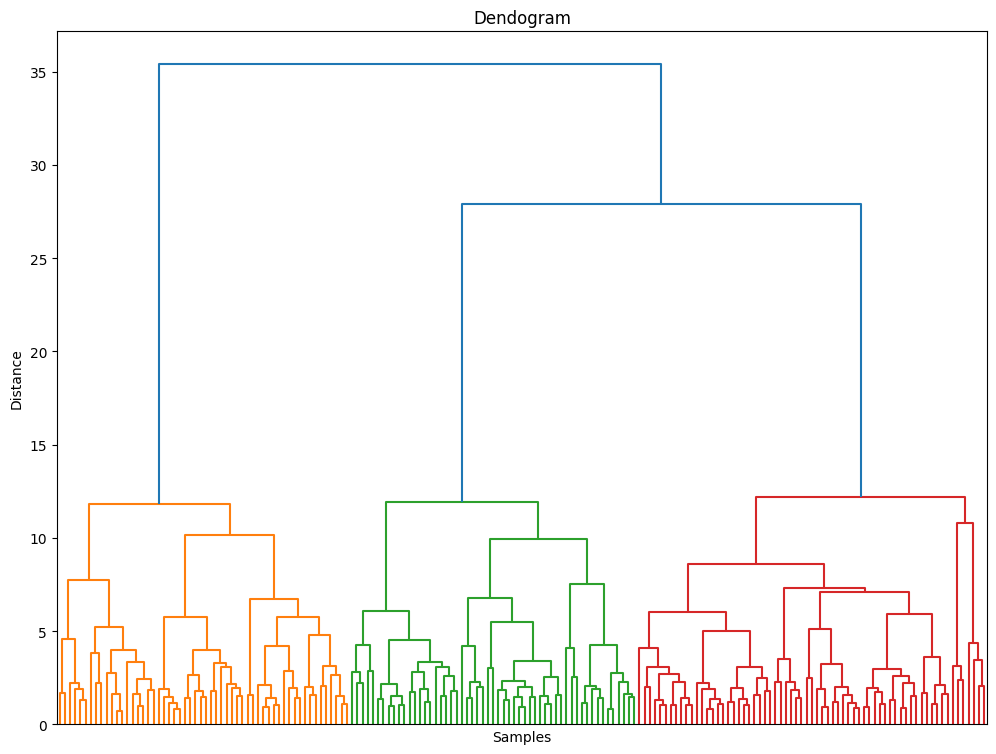

In [23]:
dendogram_graph(
    dataset            = df_pca,
    method             = dendogram_parameters["method"], 
    metric             = dendogram_parameters["metric"], 
    height_graph       = dendogram_parameters["height_graph"], 
    width_graph        = dendogram_parameters["width_graph"] 
)



In [24]:
h_model_with_dbscan = AgglomerativeClustering( 
    n_clusters         = 3,
    linkage            = "ward", 
    metric             = "euclidean", 
)

h_model_with_dbscan.fit(df_pca)

AgglomerativeClustering(n_clusters=3)

In [25]:
# Verify the quality of clusters builded with silhoutte score. 

silhoutte = silhouette_score(
    df_pca, 
    h_model_with_dbscan.labels_, 
    metric="euclidean"
)

print(f"A silhueta do modelo é de aproximadamente {silhoutte.round(3)}")

A silhueta do modelo é de aproximadamente 0.305


In [26]:
# Verify the quality of clusters builded with Davis Bouldin.

davis_bouldin = davies_bouldin_score(
    df_pca, 
    h_model_with_dbscan.labels_
) 

print(f"Índice Davis Bouldin do modelo : {davis_bouldin.round(3)}")

Índice Davis Bouldin do modelo : 1.263


#### Visualizando os clusters formados por cada modelo

In [27]:
def visualize_cluster(X: float, y: int, size : int):
    """
    Function that build a cluster graph for cluster's visualization 
    """
    # Noting the labels for each points
    unique_labels = set(y)

    # Building the graph with the labels. 
    for label in unique_labels:
        plt.scatter(X[y==label][:, 0], X[y==label][:, 1], s = size, label = f"Cluster {label}")

    plt.legend(loc="upper right")

    plt.show()

In [28]:
X_array = np.array(df_normalized)
y_array = np.array(h_model.fit_predict(df_normalized))

X_array_with_dbscan = np.array(df_pca)
y_array_with_dbscan = np.array(h_model_with_dbscan.fit_predict(df_pca))

##### Sem PCA

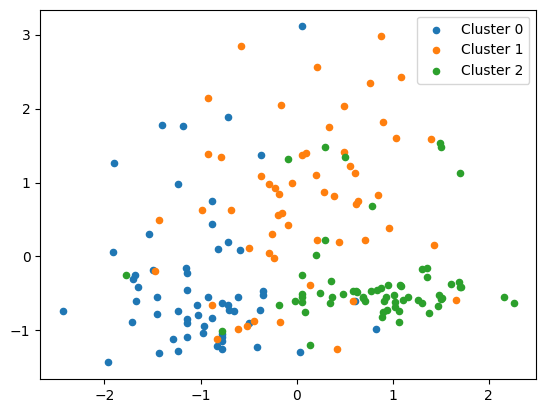

In [29]:
visualize_cluster(
    X    = X_array, 
    y    = y_array, 
    size = 20
)

#### Com PCA

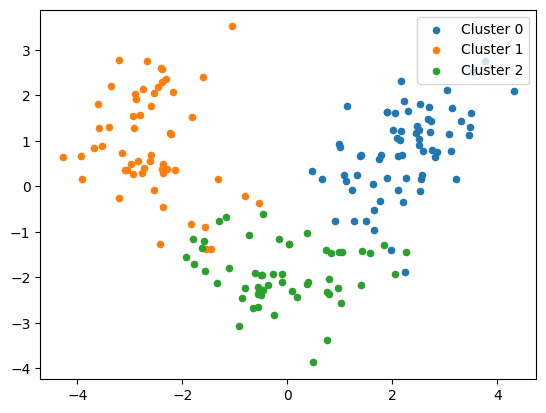

In [30]:
visualize_cluster(
    X    = X_array_with_dbscan, 
    y    = y_array_with_dbscan, 
    size = 20
)


Visualzando ambos os gráficos, consegue-se identificar a presença de três clusters presentes no dataset. Contudo, nota-se que a clusterização que utilizou da redução da dimensionalidade apresentou uma melhor compreensão dos clusters presentes em comparação com a que não utilizou. Isso pode ser justificado, pois algoritmos que utilizam de métricas de distância baseadas em magnitude para formar a sua decisão no dataset podem ser prejudicados com uma quantidade elevada de dimensionalidade. 

Ao reduzir-se a dimensionalidade para apenas 8 ao invés de 13, melhora-se a precisão do modelo no espaço dimensional, contribuindo com o incremento na compreensão dos clusters presentes. 